# Scalable Recommendation with Poisson Factorization
#### The following notebook is an implementation of the mean-field variational algorithm for approximate posterior inference for the Hierarchical Poisson Factorization, by Gopalan et al. (2013), followed by some visualizations.

In [0]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import scipy.stats
import sklearn.metrics

For the sake of simplicity, we start by fitting a very simple array of data. I created some clusters of consumers, in order to assess whether the model succeed in suggesting items which was liked by similar users.

Our data consists of only 10 users and 15 items, organized in the array ratings_toy.

In [0]:
ratings_toy = [[0,0,0,0,0,1,1,1,0,0,0,0,1,0,0],[0,0,0,0,0,1,1,0,0,0,0,1,1,0,0],[0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,1,0,0,0,1,1,0,0],[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,1,0,0,0,0,0,0,0,0,1,1],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]
ratings_toy = np.array(ratings_toy)

We are in a parametric framework, hence the number of latent components is fixed. This hypothesis suggests that the model choice will not be automatic as in a non-parametric setup. Nevertheless, I ignore these difficulties for the moment, and fix $K$ to be equal to 10.

## Initialization
First of all, recall that in the generative process the priors for user preferences $\theta_u$ and item attributes $\beta_i$ are as follows:
$$\theta_u \sim Gamma(a,\xi_u)$$
$$\beta_i \sim Gamma(c,\eta_i)$$
where the hyperpriors on $\xi_u$ and $\eta_i$ are the following:
$$ \xi_u \sim Gamma(a',a'/b') $$
$$ \eta_i \sim Gamma(c',c'/d') $$

Since the Gamma parameters are shape and rate, the expected values of $\xi_u$ and $\eta_i$ are respectively:
$$ E(\xi_u) = \frac{a'}{a'/b'} = b' $$
$$ E(\eta_i) = \frac{c'}{c'/d'} = d' $$

The variational distributions of $\theta_u \ \forall u$ and $\beta_i \ \forall i$ are the following:
$$\theta_u \sim Gamma(\gamma^{shp}_{uk},\gamma^{rte}_{uk}) $$
$$\theta_u \sim Gamma(\lambda^{shp}_{ik},\lambda^{rte}_{ik}) $$

Hence, it is natural to initialize the user parameters $\gamma_u$, and the item parameters $\lambda_i$ to the prior, plus a small random offset generated with a $Uniform(0,1)$.

In this way, $\gamma^{shp}_{uk} = a$ and $\gamma^{rte}_{uk} = a/b'$, so that the expectation of the variational $\theta$ is $b'$. Similarly, $\lambda_{ik}^{shp} = c$ and $\lambda_{ik}^{rte} = c/d'$, so that the expectation of the variational $\theta$ is $d'$.

Going up in the hierarchy, for the same reason, we set the variational parameters of $\xi_u$ and $\eta_i$, which are $k^{rte}_u$ and $\tau_i^{rte}$, to the prior, plus the same small random offset.


In [0]:
K = 10 # latent preferences/popularity

lambda_shp = np.zeros(shape = (ratings_toy.shape[1],K))
lambda_rte = np.zeros(shape = (ratings_toy.shape[1],K))

gamma_shp = np.zeros(shape = (ratings_toy.shape[0],K))
gamma_rte = np.zeros(shape = (ratings_toy.shape[0],K))

k_shp = np.zeros(ratings_toy.shape[0])
k_rte = np.zeros(ratings_toy.shape[0])

tau_shp = np.zeros(ratings_toy.shape[1])
tau_rte = np.zeros(ratings_toy.shape[1])

phi = np.zeros(shape = (ratings_toy.shape[0],ratings_toy.shape[1],K))

#%% Hyperparameters (as suggested in Gopalan et al. 2013)
a, c, a1, b1, c1, d1 = 0.3, 0.3, 0.3, 1, 0.3, 1
#%% Initialization (with a small offset"?)
count = 0
for u in range(ratings_toy.shape[0]):
    gamma_shp[u] = np.repeat(a,K) + np.random.uniform(0,1,K)
    gamma_rte[u] = np.repeat(a/b1,K) + np.random.uniform(0,1,K)
    k_rte[u] = a1/b1 + np.random.uniform(0,1)
    k_shp[u] = a1 + K*a


for i in range(ratings_toy.shape[1]):
    lambda_shp[i] = np.repeat(c,K) + np.random.uniform(0,1,K)
    lambda_rte[i] = np.repeat(c/d1,K) + np.random.uniform(0,1,K)
    tau_rte[i] = c1/d1 + np.random.uniform(0,1)
    tau_shp[i] = c1 + K*c

##The algorithm

This is the core of the mean-field variational algorithm. For details, see Gopalan et al. (2013).

In [137]:
iterations = 10 # sostituire con un while loop con convergenza recall o simili
for iter in range(iterations):
    for u in range(ratings_toy.shape[0]):
        for i in range(ratings_toy.shape[1]):
            phi[u,i] = [np.exp(scipy.special.digamma(gamma_shp[u,k]) - np.log(gamma_rte[u,k]) + scipy.special.digamma(lambda_shp[i,k]) - np.log(lambda_rte[i,k])) for k in range(K)]
            phi[u,i] = phi[u,i] / np.sum(phi[u,i])
    
    for u in range(ratings_toy.shape[0]):
        gamma_shp[u] = [a + np.sum(ratings_toy[u]*phi[u,:,k]) for k in range(K)]
        gamma_rte[u] = [k_shp[u]/k_rte[u] + np.sum(lambda_shp[:,k]/lambda_rte[:,k]) for k in range(K)]
        k_rte[u] = a1/b1 + np.sum(gamma_shp[u]/gamma_rte[u])

    for i in range(ratings_toy.shape[1]):
        lambda_shp[i] = [c + np.sum(ratings_toy[:,i]*phi[:,i,k]) for k in range(K)]
        lambda_rte[i] = [tau_shp[i]/tau_rte[i] + np.sum(gamma_shp[:,k]/gamma_rte[:,k]) for k in range(K)]
        tau_rte[i] = c1/d1 + np.sum(lambda_shp[i]/lambda_rte[i])
    print(f"Iteration {iter} completed")
print("Completed")

Completed


## Reversing again the generative process
Now, we use the generative structure of the model to obtain the estimates for the entry of the observed matrix. In particular, we are going to generate the user preferences $\theta$ and the item attributes $\beta$, such that we can sample observation from a Poisson: $y_{ui} \sim Poisson(\beta_i\theta_u)$.

Note that in order to obtain generate the observation we need some Bayesian estimates of $\theta_u$ and $\beta_i$: hence, we  take the expectation of their variational distributions, which as always is the ratio between shape and scale.


In [0]:
# (using expectation of var. distr.)
theta = np.zeros(shape = (ratings_toy.shape[0],K))
beta = np.zeros(shape = (ratings_toy.shape[1],K))

theta = gamma_shp/gamma_rte
beta = lambda_shp/lambda_rte

# %% Generating observations y
ratings_pred = np.dot(theta, beta.T)


##Plotting some results
In the following, we can qualitatively assess the in-sample performance of the model by comparing the actual vs predicted observations for the first 3 users of our dataset.

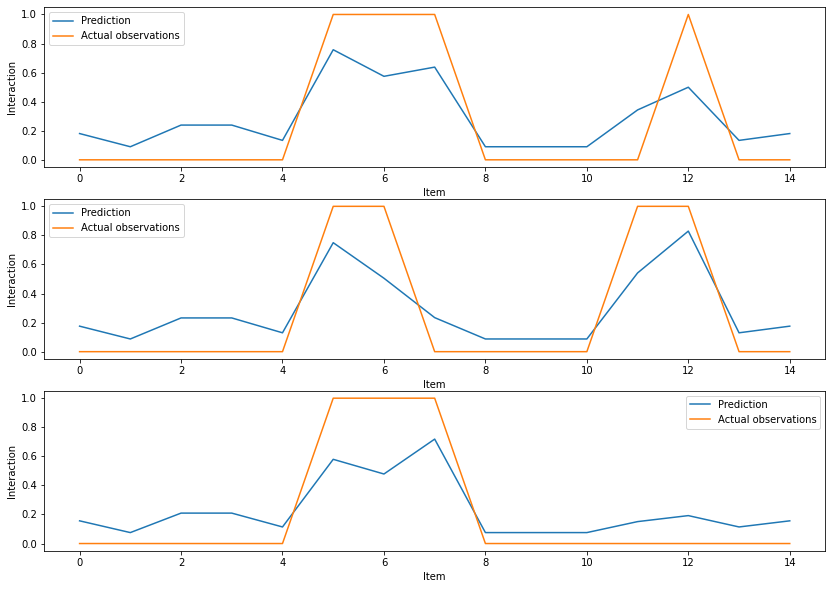

In [189]:
fig, axes = plt.subplots(figsize=(14, 10), nrows=3)
for u in range(3):
    axes[u].plot(ratings_pred[u], label = "Prediction")
    axes[u].plot(ratings_toy[u], label = "Actual observations")
    axes[u].set_xlabel("Item")
    axes[u].set_ylabel("Interaction")
    axes[u].legend();

## A simple example of recommendation

Now we can have some fun with the trained model. In the following, we give some names to users and items, which will be movie, as to suggest what to watch next.

Note however this is a toy example (no hyperparameter tuning, out-of-sample evaluation etc...), so we should not take it too seriously!

In [193]:
ranking = np.zeros(shape = (ratings_toy.shape[0], ratings_toy.shape[1]))
names = ["Anna", "Baldo", "Carlo", "Dante", "Emma", "Fabio", "Giorgio", "Helena", "Ida", "Lando"]
movies = ["Lo squalo", "Quei bravi ragazzi", "Apocalypse Now", "Cantando sotto la pioggia", "Pulp Fiction", "Fight Club", "Toro scatenato", "L'appartamento", "C'era una volta il West"]

for j,u in enumerate(names):
    for h,i in enumerate(movies):
        ranking[j] = ratings_pred[j]-ratings_toy[j]
        if ranking[j,h] > 0.3:
            print(f"Hey {u}! You may also like this movie: {i}")

Hey Dante! You may also like this movie: Toro scatenato
Hey Fabio! You may also like this movie: Cantando sotto la pioggia
Hey Helena! You may also like this movie: Apocalypse Now
